In [1]:
import torch
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [2]:
### PARAMETERS ###
dataset_ver = '3w05s_Larm'
n_input = 9
n_hidden = 360
num_epochs = 20
encoder_ver = f'{n_hidden}h{num_epochs}e'

x_train = np.load(f'Generated_Datasets/train_data_{dataset_ver}.npy')
x_val = np.load(f'Generated_Datasets/val_data_{dataset_ver}.npy')
x_test = np.load(f'Generated_Datasets/test_data_{dataset_ver}.npy')

y_train = np.load(f'Generated_Datasets/train_labels_{dataset_ver}.npy')
y_val = np.load(f'Generated_Datasets/val_labels_{dataset_ver}.npy')
y_test = np.load(f'Generated_Datasets/test_labels_{dataset_ver}.npy')

In [3]:
print(x_train.shape)
print(x_val.shape)

(15407, 60, 9)
(2202, 60, 9)


(15407, 60, 9) (4403, 60, 9) (2202, 60, 9)


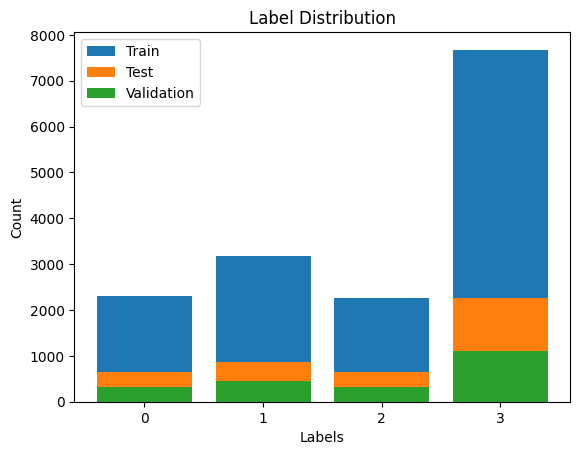

In [4]:
# Check Dataset
print(x_train.shape, x_test.shape, x_val.shape)
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_type, dataset_ver):
        self.X = np.array(np.load(f'Generated_Datasets/{dataset_type}_data_{dataset_ver}.npy'))
        self.y = np.array(np.load(f'Generated_Datasets/{dataset_type}_labels_{dataset_ver}.npy'))

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = torch.from_numpy(self.X[idx]).float()
        y = torch.from_numpy(np.asarray(self.y[idx])).float()
        return X, y

In [6]:
# Unidirectional LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size*2, batch_first=True)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        x, (_, _) = self.LSTM1(x)
        x, (encoded_x, _) = self.LSTM2(x)
        return encoded_x[-1,:,:]


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.LSTM2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size*2, batch_first=True)
        self.output = nn.Linear(self.hidden_size*2, output_size)

    def forward(self, x):
        # x = x.repeat(60, 1, 1)
        # x = x.reshape(x.shape[1], 60, self.hidden_size)
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x, (_, _) = self.LSTM1(x)
        x, (_, _) = self.LSTM2(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size).to(device)
        self.decoder = Decoder(hidden_size, in_out_size).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
autoencoder = Autoencoder(n_input, n_hidden).to(device)
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 720, batch_first=True)
    (LSTM2): LSTM(720, 360, batch_first=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True)
    (LSTM2): LSTM(360, 720, batch_first=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)


In [13]:
# Bidirectional LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.hidden_size = hidden_size

    def forward(self, x):
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (encoded_x, _) = self.LSTM2(x)
        # Concatenate Forward + Backward Pass - (seq_len, batch, num_directions * hidden_size)  
        encoded_x = (encoded_x[0, :, :] + encoded_x[1, :, :])
        # print("Final Encoded: ", encoded_x.shape)
        return encoded_x


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.output = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        # print("Decoder x: ", x.shape)
        x = x.unsqueeze(1).repeat(1, 60, 1)
        # print("Reshaped Decoder x: ", x.shape)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (_, _) = self.LSTM2(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size).to(device)
        self.decoder = Decoder(hidden_size, in_out_size).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [49]:
# RNN
class DANA(nn.Module):
    def __init__(self, inp_shape, out_shape):
        super(DANA, self).__init__()
        nb_filters = 64
        drp_out_dns = 0.5
        nb_dense = 512
        nb_dropout = 128

        self.conv = nn.Conv1d(inp_shape, nb_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(nb_filters, nb_dense, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(nb_dense*2, nb_dropout)
        self.dropout = nn.Dropout(drp_out_dns)
        self.fc2 = nn.Linear(nb_dropout, out_shape)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # conv = (batch, no of channels, sequence length)
        x = self.conv(x)
        x = self.relu(x)
        # print("CONV:", x.shape)
        x = x.permute(0, 2, 1)
        # print(x.shape)
        x, _ = self.lstm(x) # lstm = (batch, seq length, input_size)
        x = x[:, -1]
        # print("LSTM:",x.shape)
        x = self.fc1(x)
        # print("Linear1:",x.shape)
        x = self.dropout(x)
        x = self.fc2(x)
        # print("Linear2:",x.shape)

        return x

autoencoder = DANA(n_input, n_input).to(device)
print(autoencoder)

DANA(
  (conv): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (lstm): LSTM(64, 512, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
  (loss): MSELoss()
)


In [14]:
### Train AutoEncoder ###
train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = CustomDataset("val", dataset_ver)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

### Define Model ###
autoencoder = Autoencoder(n_input, n_hidden).to(device)
# autoencoder = LSTM(n_input, n_hidden, 3, 0.5, True)
# autoencoder = DANA(n_input, n_input).to(device)
print(autoencoder)


optimizer = optim.Adam(autoencoder.parameters(),
                        lr=1e-3,
                        betas=(0.9, 0.999),
                        eps=1e-8)
optimizer.zero_grad()

best_loss = np.inf
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f'Starting Epoch {epoch+1}...')
    
    autoencoder.train()
    for X_batch, _ in tqdm(train_dataloader):
        X = X_batch.to(device)

        pred = autoencoder(X)
        train_loss = autoencoder.loss(pred, X)

        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_losses.append(train_loss.item())
    
    autoencoder.eval()
    val_loss = 0.0
    for X_batch, _ in tqdm(val_dataloader):
        X = X_batch.to(device)

        pred = autoencoder(X)
        val_loss += autoencoder.loss(pred, X).item() * X_batch.size(0)

    val_losses.append(val_loss / len(val_dataset))

    print(f'Epoch [{epoch+1}/{num_epochs}]\nTraining Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    if val_losses[-1] < best_loss:
        best_loss = val_losses[-1]

        # Save Encoder
        torch.save(autoencoder.encoder, f'ML_Models/{dataset_ver}_{encoder_ver}_encoder.pt')
        # Save Full Autoencoder
        torch.save(autoencoder, f'ML_Models/{dataset_ver}_{encoder_ver}_Autoencoder.pt')


Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [1/20]
Training Loss: 0.0212, Val Loss: 0.0166
Starting Epoch 2...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [2/20]
Training Loss: 0.0074, Val Loss: 0.0099
Starting Epoch 3...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [3/20]
Training Loss: 0.0064, Val Loss: 0.0072
Starting Epoch 4...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [4/20]
Training Loss: 0.0078, Val Loss: 0.0063
Starting Epoch 5...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [5/20]
Training Loss: 0.0061, Val Loss: 0.0059
Starting Epoch 6...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [6/20]
Training Loss: 0.0081, Val Loss: 0.0054
Starting Epoch 7...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [7/20]
Training Loss: 0.0057, Val Loss: 0.0047
Starting Epoch 8...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [8/20]
Training Loss: 0.0040, Val Loss: 0.0044
Starting Epoch 9...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [9/20]
Training Loss: 0.0046, Val Loss: 0.0043
Starting Epoch 10...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [10/20]
Training Loss: 0.0031, Val Loss: 0.0037
Starting Epoch 11...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [11/20]
Training Loss: 0.0045, Val Loss: 0.0037
Starting Epoch 12...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [12/20]
Training Loss: 0.0035, Val Loss: 0.0034
Starting Epoch 13...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [13/20]
Training Loss: 0.0028, Val Loss: 0.0035
Starting Epoch 14...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [14/20]
Training Loss: 0.0032, Val Loss: 0.0030
Starting Epoch 15...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [15/20]
Training Loss: 0.0043, Val Loss: 0.0032
Starting Epoch 16...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [16/20]
Training Loss: 0.0035, Val Loss: 0.0028
Starting Epoch 17...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [17/20]
Training Loss: 0.0025, Val Loss: 0.0028
Starting Epoch 18...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [18/20]
Training Loss: 0.0022, Val Loss: 0.0028
Starting Epoch 19...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [19/20]
Training Loss: 0.0022, Val Loss: 0.0027
Starting Epoch 20...


  0%|          | 0/963 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

Epoch [20/20]
Training Loss: 0.0032, Val Loss: 0.0026


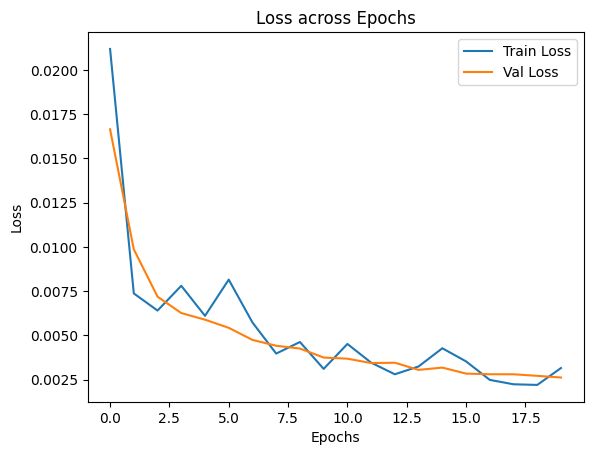

In [19]:
plt.plot(range(len(train_losses)), train_losses, label= 'Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss across Epochs')
plt.legend()
plt.show()

In [20]:
### Train SVM ###
def train_svm(train_data, train_labels):
    x_train, x_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.20, random_state=0)
    svm_classifier = svm.SVC(kernel='rbf', probability=True)
    svm_classifier.fit(x_train, y_train)

    test_pred = svm_classifier.predict(x_test)
    print(f'Accuracy: {accuracy_score(y_test, test_pred)}')

    return svm_classifier

train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
print('Loading Encoder Model...')
encoder = torch.load(f'ML_Models/{dataset_ver}_{encoder_ver}_encoder.pt').to(device)
encoder.eval()

encoded_data = []
labels = []

print('Encoding Data...')
with torch.no_grad():
    for batch in tqdm(train_dataloader):
        X_batch, y_batch = batch
        X = X_batch.to(device)
        y = y_batch.to(device).reshape(-1, 1)

        encoded_batch = encoder(X)
        # print(encoded_batch.shape)

        ### for unidirectional LSTM ###
        # encoded_batch = encoded_batch.reshape(encoded_batch.shape[1], encoded_batch.shape[2])

        ### bidirectional LSTM have hidden states in 2 dimensions ###
        # h_1, h_2 = encoded_batch[0], encoded_batch[1]
        # encoded_batch = torch.cat((h_1, h_2), 1)
        
        encoded_data.append(encoded_batch)
        labels.append(y)

    encoded_data = torch.cat(encoded_data, 0).cpu()
    labels = torch.cat(labels, 0).cpu()       

print(f'{encoded_data.shape=}')
print(f'{labels.shape=}')

print("Training SVM Classifier...")
svm_classifier = train_svm(encoded_data, labels.ravel())

# Save SVM Classifier
with open(f'ML_Models/{dataset_ver}_{encoder_ver}_svm_classifier.pkl', "wb") as file:
    pickle.dump(svm_classifier, file)

Loading Encoder Model...
Encoding Data...


  0%|          | 0/963 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([15407, 360])
labels.shape=torch.Size([15407, 1])
Training SVM Classifier...
Accuracy: 0.9325113562621674


In [21]:
### Test SVM + Encoder ###

# Model Params
encoder_ver = f'{n_hidden}h{num_epochs}e'
test_dataset = CustomDataset("test", dataset_ver)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Load the saved models
encoder = torch.load(f'ML_Models/{dataset_ver}_{encoder_ver}_encoder.pt')
encoder.eval()
with open(f'ML_Models/{dataset_ver}_{encoder_ver}_svm_classifier.pkl', 'rb') as file:
    svm_classifier = pickle.load(file)

test_encoded_data = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        X_batch, y_batch = batch
        X = X_batch.to(device)
        y = y_batch.to(device).reshape(-1, 1)

        test_encoded_batch = encoder(X)
        # print(encoded_batch.shape)
        
        ### for unidirectional LSTM ###
        # encoded_batch = encoded_batch.reshape(encoded_batch.shape[1], encoded_batch.shape[2])
        
        ### bidirectional LSTM have hidden states in 2 dimensions ###
        # h_1, h_2 = encoded_batch[0], encoded_batch[1]
        # encoded_batch = torch.cat((h_1, h_2), 1)
        
        test_encoded_data.append(test_encoded_batch)
        test_labels.append(y)

    test_encoded_data = torch.cat(test_encoded_data, 0).cpu()
    test_labels = torch.cat(test_labels, 0).cpu()   

print(f'{test_encoded_data.shape=}')
print(f'{test_labels.shape=}')

test_predictions = svm_classifier.predict(test_encoded_data)
print(f'{test_predictions.shape=}')

  0%|          | 0/276 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([4403, 360])
test_labels.shape=torch.Size([4403, 1])
test_predictions.shape=(4403,)


Accuracy: 93.71%


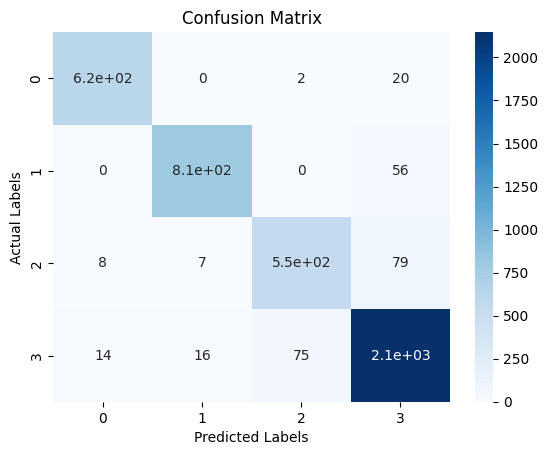

In [22]:
# Calculate accuracy score
accuracy = accuracy_score(test_labels, test_predictions)
accuracy_percentage = accuracy * 100
print(f"Accuracy: {accuracy_percentage:.2f}%")

# Create a confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues')

# Add labels and title to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()